## EECS 491 Assignment 3

### Exercise 1. MRFs and Images Denoising (40 points)

In this problem, you will implement the image de-noising example using a Markov Random Field (MRF).  This material on MRFs is covered in the textbook (Barber) in chapter 4.2.5. The lecture and this problem is based on the presentation in Bishop in chapter 8.3, which is available online.

As discussed in class, energy function for this MRF is

$$ E(\mathbf{x}, \mathbf{y}) = h \sum_i x_i - \beta \sum_i\sum_{j\in \textrm{ne}(i)} x_i x_j - \eta \sum_i x_i y_i \quad(1)$$

where the binary variables $x_i$ represent the unknown, noise-free image pixels, which are binary, i.e. black or white, and $\textrm{ne}(i)$ indicates the neighbords of node $i$.  The variables $y_i$ represent the observed noisy pixels, i.e. the pixel could randomly change from black ($=-1$) to white ($=+1$) or vice-versa.  

The corresponding joint probability distribution over the variables is

$$ p(\mathbf{x},\mathbf{y}) = \frac{1}{Z} \exp \left[ -E(\mathbf{x},\mathbf{y}) \right] $$

1.1 (5 pts) Derive the equation that specifies the change in the energy equation when one variable changes state.

Representing the variable which changes state as $x_a$, then the change in energy can be defined as

$$\Delta E(\mathbf{x,y}) = E(\mathbf{x^*,y}) - E(\mathbf{x,y}),$$

where $\mathbf{x^*}$ is $\mathbf{x}$ with $-x_a$ instead of $x_a$. In order to find the change in energy, we will need to find the energy with respect to one variable. The total energy equation consists of three terms, so we will break it down into these respective parts. The energy from the first term with respect to one variable is

$$hx_a,$$

and the energy from the third term is

$$-\eta(x_ay_a).$$

The energy from the second term is the effect of $x_a$ on its neighbors, which can be written as

$$-2\beta x_a\sum_{i\in ne(a)}x_i.$$

Writing out the total change, we get

$$\Delta E(\mathbf{x,y}) = h(-x_a - x_a) -2\beta(-\sum_{i\in ne(a)}x_ix_a -\sum_{i\in ne(a)}x_ix_a) -\eta(-x_ay_a - x_ay_a)$$

$$\Delta E(\mathbf{x,y}) = -2hx_a + 4\beta x_a\sum_{i\in ne(a)}x_i + 2\eta x_ay_a$$

$$\Delta E(\mathbf{x,y}) = x_a(-2h + 4\beta\sum_{i\in ne(a)}x_i + 2\eta y_a)\quad(2)$$

1.2 (10 pts) Write a program to iteratively (or in random order) update the state variables to minimize the energy (maximize the probability).  Explain your code.  Show that the update algorithm minimizes the energy $E(\mathbf{x}, \mathbf{y})$.

In [172]:
import numpy as np

def sumNeighbor(x,rInd,cInd):
    # sum(x_i x_j) for j in the neighborhood of i
    if len(x) == (rInd+1):
        down = x[0,cInd]
    else:
        down = x[rInd+1,cInd]
    if len(x[0]) == (cInd+1):
        right = x[rInd,0]
    else:
        right = x[rInd,cInd+1]
    up = x[rInd-1,cInd]
    left = x[rInd,cInd-1]
    total = right+left+up+down
    return total

def deltaEnergy(x,y,h,b,n,rInd,cInd):
    # compute the change in energy using Equation 2
    dE = x[rInd,cInd]*(-2*h + 4*b*sumNeighbor(x,rInd,cInd) + 2*n*y[rInd,cInd])
    return dE

def totalEnergy(x,y,h,b,n):
    # compute the total energy using Equation 1
    total1 = 0
    total2 = 0
    total3 = 0
    for rInd in range(len(x)):
        for cInd in range(len(x[0])):
            total1 = total1 + x[rInd,cInd]
            total2 = total2 + x[rInd,cInd]*sumNeighbor(x,rInd,cInd)
            total3 = total3 + x[rInd,cInd]*y[rInd,cInd]
    
    E = h*total1 - b*total2 - n*total3
    
    return E

def minEnergy(x,y,h,b,n,maxIter):
    # minimize the energy using the Iterated Conditional Modes (ICM) technique
    iter = 0
    changed = 1
    while (iter < maxIter) and (changed > 0):
        changed = 0
        for rInd in range(len(x)):
            for cInd in range(len(x[0])):
                dE = deltaEnergy(x,y,h,b,n,rInd,cInd)
                """energyPre = totalEnergy(x,y,h,b,n)
                #print(x[rInd][cInd])
                x[rInd][cInd] = -1*x[rInd][cInd]
                #print(x[rInd][cInd])
                energyPost = totalEnergy(x,y,h,b,n)
                if energyPost >= energyPre:"""
                if dE < 0:
                    x[rInd][cInd] = -x[rInd][cInd]
                    changed = 1
        
        iter = iter + 1
    #print(iter)
    return x

Energy before:  -386.0
Energy after:  -526.0


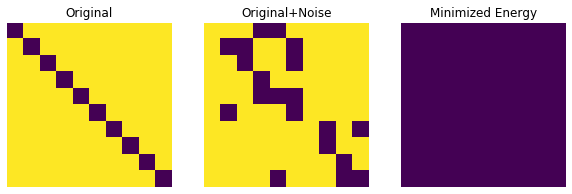

In [178]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

img = np.eye(10)
for rInd in range(len(img)):
    for cInd in range(len(img[0])):
        if img[rInd,cInd] < 1:
            img[rInd,cInd] = -1
img = -img
y = np.copy(img)

for rInd in range(len(y)):
    for cInd in range(len(y[0])):
        change = np.random.binomial(1,0.1)
        if change > 0:
            y[rInd,cInd] = -1*y[rInd,cInd]

b = 1.0
n = 2.1
h = 0.0

x = np.copy(y)
print("Energy before: ",totalEnergy(x,y,h,b,n))
x = minEnergy(x,y,h,b,n,100)

print("Energy after: ",totalEnergy(x,y,h,b,n))
            
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original")
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(y)
plt.title("Original+Noise")
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(x)
plt.title("Minimized Energy")
plt.axis('off')
plt.show()

1.3 (10 pts) Illustrate the model by plot of the image as it is being de-noised at the beginning, middle, and end of the updating.  Choose images that aren't too high resolution so that the individual pixels are visible as squaures.  You may also do a live plot in a notebook to show it updating continuously, but make sure you have the static plots too in case the dynamic plot has portability issues.

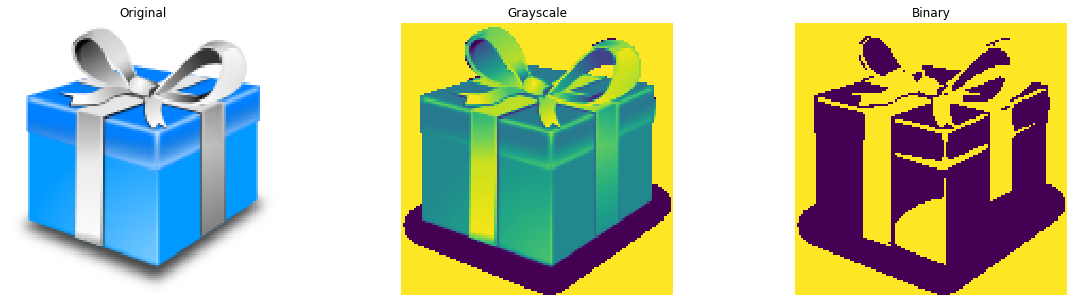

In [179]:
import matplotlib.cbook as cbook

# Image Conditioning

with cbook.get_sample_data('Minduka_Present_Blue_Pack.png') as image_file:
    image = plt.imread(image_file)
    
rgb_weights = [0.2989, 0.5870, 0.1140]
grayscale_image = np.dot(image[...,:3], rgb_weights)
binary_image = np.copy(grayscale_image)
for rInd in range(len(binary_image)):
    for cInd in range(len(binary_image[0])):
        if binary_image[rInd,cInd] > 0.6:
            binary_image[rInd,cInd] = 1
        else:
            binary_image[rInd,cInd] = -1
            
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.imshow(image)
plt.title("Original")
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(grayscale_image)
plt.title("Grayscale")
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(binary_image)
plt.title("Binary")
plt.axis('off')
plt.show()

Energy before:  -72494.4
Energy after:  -87054.8


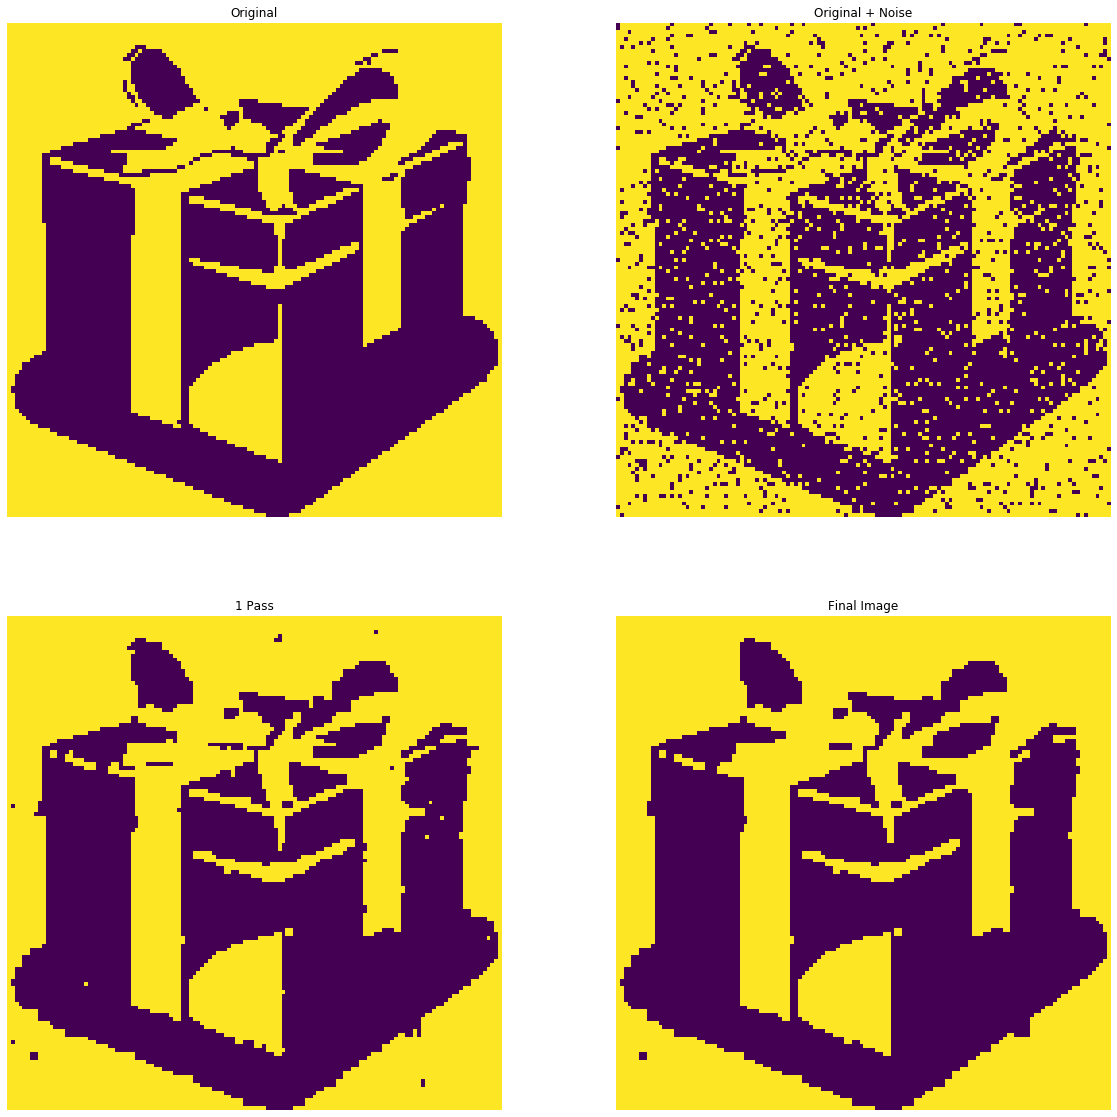

In [180]:
# make the image noisy
y = np.copy(binary_image)

for rInd in range(len(y)):
    for cInd in range(len(y[0])):
        change = np.random.binomial(1,0.1)
        if change > 0:
            y[rInd,cInd] = -1*y[rInd,cInd]

plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(binary_image)
plt.title("Original")
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(y)
plt.title("Original + Noise")
plt.axis('off')

x = np.copy(y)
print("Energy before: ",totalEnergy(x,y,h,b,n))
x = minEnergy(x,y,h,b,n,1)

plt.subplot(2,2,3)
plt.imshow(x)
plt.title("1 Pass")
plt.axis('off')

x = minEnergy(x,y,h,b,n,100)
plt.subplot(2,2,4)
plt.imshow(x)
plt.title("Final Image")
plt.axis('off')
print("Energy after: ",totalEnergy(x,y,h,b,n))

plt.show()

1.4 (5 pts) Experiment with different settings of the energy equation parameters and explain your results.

1.5 (10 pts)  Generalize the energy equation so that the model considers more that just pairs of pixels.  Explain your rationale behind this new model. Illustrate it with denoising examples (other types of images) with are not well-handled by the previous model.

### Exercise 2. Graphical Representation (15 points)

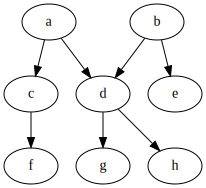

In [1]:
from graphviz import Digraph

q1 = Digraph()
q1.node('a') # variable name, label
q1.node('b')
q1.node('c')
q1.node('d')
q1.node('e')
q1.node('f')
q1.node('g')
q1.node('h')
q1.edges(['ac', 'ad', 'bd', 'be', 'cf', 'dg', 'dh'])
# render inline
q1

2.1 (5 pts) For the Bayesian network show above, draw the corresponding Markov Random Field (MRF), and write out the joint probability using potential functions.  You do not need to specify the functions themselves, only which arguments they take.

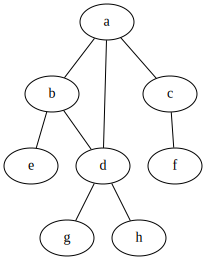

In [2]:
from graphviz import Graph

q1m = Graph()
q1m.node('a')
q1m.node('b')
q1m.node('c')
q1m.node('d')
q1m.node('e')
q1m.node('f')
q1m.node('g')
q1m.node('h')
q1m.edges(['ab', 'ad', 'bd', 'ac', 'be', 'cf', 'dg', 'dh'])
# render inline
q1m

The Markov Random Field which represents the directed bayesian network is depicted above. When converting a directed to an undirected representation, the original relationship between a,b, and d cannot be directly represented. So, an edge is added to represent the relationship between a and b. Otherwise, all edges just have their directionality removed. Writing this MRF as the product of clique potential functions is

$$p(X) = \frac{1}{Z}\psi(a,b,d)\psi(a,c)\psi(b,e)\psi(c,f)\psi(d,g)\psi(d,h)$$

2.2 (5 pts) Now specify the Bayes net as a factor graph.  Again write the expression for the joint probability, but using factor functions.

Writing the original bayesian network, we get the following product of conditional probabilities:

$$p(X) = p(f|c)p(g|d)p(h|d)p(c|a)p(d|a,b)p(e|b)p(a)p(b).$$

Rewriting as a factor graph, we get

$$p(X) = f_f(c,f)f_g(d,g)f_h(d,h)f_c(a,c)f_d(a,b,d)f_e(b,e)f_a(a)f_b(b)$$

with the factor graph displayed below.

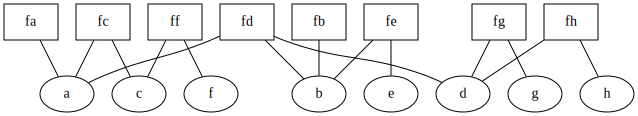

In [3]:
q1f = Graph()
q1f.node('a')
q1f.node('b')
q1f.node('c')
q1f.node('d')
q1f.node('e')
q1f.node('f')
q1f.node('g')
q1f.node('h')

q1f.attr('node', shape='box')
q1f.node('fa')
q1f.node('fb')
q1f.node('fc')
q1f.node('fd')
q1f.node('fe')
q1f.node('ff')
q1f.node('fg')
q1f.node('fh')

q1f.edge('fa','a')
q1f.edge('fb','b')
q1f.edge('fc','a')
q1f.edge('fc','c')
q1f.edge('fd','a')
q1f.edge('fd','b')
q1f.edge('fd','d')
q1f.edge('fe','b')
q1f.edge('fe','e')
q1f.edge('ff','c')
q1f.edge('ff','f')
q1f.edge('fg','d')
q1f.edge('fg','g')
q1f.edge('fh','d')
q1f.edge('fh','h')

q1f

2.3 (5 pts) Express the following Bayes net (from the sprinkler example) in two different factor graphs.  For each network, write the factors as a function of the conditional probabilties and specify the joint probability.

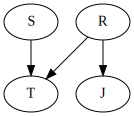

In [4]:
q2 = Digraph()
q2.node('S') # variable name, label
q2.node('R')
q2.node('T')
q2.node('J')
q2.edges(['ST', 'RT', 'RJ'])
# render inline
q2

The above network models the joint probability

$$p(X) = p(S)p(R)p(T|S,R)p(J|R).$$

One way of expressing the above network as a factor graph is

$$p(X) = f_S(S)f_R(R)f_T(R,S,T)f_J(J,R),$$

where

$$f_S(S) = p(S),$$

$$f_R(R) = p(R),$$

$$f_T(R,S,T) = p(T|R,S),$$

$$f_J(J,R) = p(J|R).$$

The factor graph is shown below.

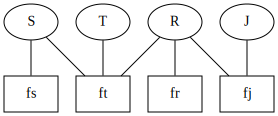

In [9]:
q21 = Graph()
q21.node('S')
q21.node('R')
q21.node('T')
q21.node('J')

q21.attr('node', shape='box')
q21.node('fs')
q21.node('ft')
q21.node('fj')
q21.node('fr')

q21.edge('S','fs')
q21.edge('S','ft')
q21.edge('R','ft')
q21.edge('T','ft')
q21.edge('R','fr')
q21.edge('R','fj')
q21.edge('J','fj')

q21

Another way of expressing the above network as a factor graph is

$$p(X) = f_T(R,S,T)f_J(J,R),$$

where

$$f_T(R,S,T) = p(R)p(S)p(T|R,S),$$

$$f_J(J,R) = p(J|R).$$

This representation is more condensed than the previous version we wrote. The factor graph is shown below.

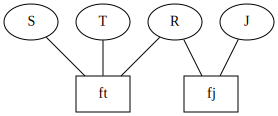

In [10]:
q22 = Graph()
q22.node('S')
q22.node('R')
q22.node('T')
q22.node('J')

q22.attr('node', shape='box')
q22.node('ft')
q22.node('fj')

q22.edge('S','ft')
q22.edge('R','ft')
q22.edge('T','ft')
q22.edge('R','fj')
q22.edge('J','fj')

q22

### Exercise 3. The Sum Product Algorithm (25 pts)

Consider the following factor graph.

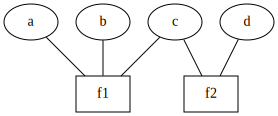

In [11]:
q3 = Graph()
q3.node('a')
q3.node('b')
q3.node('c')
q3.node('d')

q3.attr('node',shape='box')
q3.node('f1')
q3.node('f2')

q3.edge('a','f1')
q3.edge('b','f1')
q3.edge('c','f1')
q3.edge('c','f2')
q3.edge('d','f2')

q3

3.1 (10 pts) Apply the sum-product algorithm to compute the all messages when none of the variables are known.

Joint probability:

$$p(x) = f_1(a,b,c)f_2(c,d).$$

First set of messages:

$$\mu_{a\rightarrow f_1}(a) = 1,$$

$$\mu_{b\rightarrow f_1}(b) = 1,$$

$$\mu_{f_1\rightarrow c}(c) = \sum_a\sum_bf_1(a,b,c),$$

$$\mu_{c\rightarrow f_2}(c) = \mu_{f_1\rightarrow c}(c),$$

$$\mu_{f_2\rightarrow d}(d) = \sum_cf_2(c,d)\mu_{c\rightarrow f_2}(c).$$

Second set of messages:

$$\mu_{d\rightarrow d}(d) = 1,$$

$$\mu_{f_2\rightarrow c}(c) = \sum_df_2(c,d),$$

$$\mu_{c\rightarrow f_1}(c) = \mu_{f_2\rightarrow c}(c),$$

$$\mu_{f_1\rightarrow a}(a) = \sum_cf_1(a,b,c)\mu_{c\rightarrow f_1}(c),$$

$$\mu_{f_1\rightarrow b}(b) = \mu_{f_1\rightarrow a}(a).$$

3.2 (5 pts) Compute the marginal probability $p(c)$, expressing it in terms of the messages you derived in the previous question.

$$p(c) = \mu_{f_1\rightarrow c}(c)\mu_{f_2\rightarrow c}(c)$$

3.3 (5 pts) Verify that the marginal is the correct expression substituting in the message definitions.

$$p(c) = \mu_{f_1\rightarrow c}(c)\mu_{f_2\rightarrow c}(c),$$

$$p(c) = \left[\sum_a\sum_bf_1(a,b,c)\right]\left[\sum_df_2(c,d)\right],$$

$$p(c) = \sum_a\sum_b\sum_df_1(a,b,c)f_2(c,d),$$

$$p(c) = \sum_a\sum_b\sum_dp(x).$$

Now consider adding a loop to the graph.

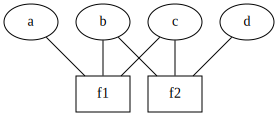

In [12]:
q4 = Graph()
q4.node('a')
q4.node('b')
q4.node('c')
q4.node('d')

q4.attr('node',shape='box')
q4.node('f1')
q4.node('f2')

q4.edge('a','f1')
q4.edge('b','f1')
q4.edge('c','f1')
q4.edge('c','f2')
q4.edge('d','f2')
q4.edge('b','f2')

q4

3.4 (5 pts) Explore the consequences of applying the sum-product algorithm to this graph. Can the algorithm still be applied?

As the graph above is presented, the application of the sum-product to a cyclic graph is more difficult than in the acyclic case. In a cyclic graph there is no way to obtain the message $\mu_{f_1\rightarrow c}(c)$ because $f_1$ and $f_2$ are dependent on each other. The most analytically straightforward method to resolve this issue is to convert the factor graph into a representation which is acyclic. Using the method presented in \[Kschischang et al 2001\], we can cluster $b$ and $c$ into one node and appropriately modify $f_1$ and $f_2$, such that the graph is no longer cyclic.

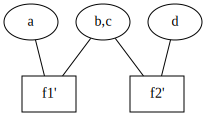

In [13]:
q4a = Graph()
q4a.node('a')
q4a.node('b,c')
q4a.node('d')

q4a.attr('node',shape='box')
q4a.node('f1\'')
q4a.node('f2\'')

q4a.edge('a','f1\'')
q4a.edge('b,c','f1\'')
q4a.edge('b,c','f2\'')
q4a.edge('d','f2\'')

q4a

Another approach would be to solve the graph in an iterative matter, starting with each outer message having a value of 1. Eventually this will converge to the correct message values.

Reference:
Kschischang, Frank R., Frey, Brendan J., Loeliger, H-A. "Factor graphs and the sum-product algorithm." *IEEE Transactions on information theory* 47.2 (2001): 498-519

### Exploration (20 points)

Select a topic from the readings (Barber chapters 4 and 5, Murphy chapters 19 and 20, or Bishop Chapter 8) and write your own exercise.  It should aim to teach or explore a concept you don't understand or found interesting.  Like before, you don't do an excessive amount of work.  This isn't a project.  Aim for something worth about 20 points, i.e. about half as much work has exercise 1 or a little more work than exercise 2.

Grading rubric:
- Clarity of explanation. Could another student read and do this? (5 pts)
- Novelty or distinctness. Does it complement or go beyond what was covered above? (5 pts)
- Does the exercise teach something about the concept(s)? (5 pts)
- How deeply does it explore the concept(s)? (5 pts)